# Does school funding impact students academic performance?

<img src="images/education-header.jpg" width="900" />



**Credit:**  [techxend](https://www.techxtend.com/site/content/education/) 

In [242]:
# Load relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
import warnings
import scipy.stats as st

#sns.set_theme(style="ticks", color_codes=True)


warnings.filterwarnings("ignore")  # Suppress all warnings

In [245]:
# read file
df = pd.read_csv('20210101/final_merged_latest.csv', index_col = 0)
df.head()

FileNotFoundError: File b'20210101/final_merged_latest.csv' does not exist

In [57]:
# columns present on the dataset
df.columns

Index(['District Code', 'Agency Name', 'Total Enrollment', 'Total Revenue',
       'Revenue per student', 'Subgroup ID', 'Count Enrollment per ethnicity',
       'County Code', 'Test Id', 'Mean Scale Score',
       'Total Tested At Entity Level', 'Total Tested with Scores',
       'CAASPP Reported Enrollment', 'Students Tested', 'Students with Scores',
       'Total Standard Exceeded', 'Total Standard Met',
       'Total Standard Met and Above', 'Total Standard Nearly Met',
       'Total Standard Not Met'],
      dtype='object')

In [58]:
#Converting all the assessment columns back to  percentage columns for exceeded, nearly met, not met to show completion results as percentage of test taken
df['Percentate Std Exceed'] =(df['Total Standard Exceeded']/df['Students Tested']*100).round(decimals=0)
df['Percentage Std Met'] =(100*df['Total Standard Met']/df['Students Tested']).round(decimals=0)
df['Percentage Std Nearly Met'] =(100*df['Total Standard Nearly Met']/df['Students Tested']).round(decimals=0)
df['Percentage Std Not Met'] =(100*df['Total Standard Not Met']/df['Students Tested']).round(decimals=0)
df['Percentage Std Met and Above'] =(100*df['Total Standard Met and Above']/df['Students Tested']).round(decimals=0)
#Percentage was multiplied by the students tested information and not the total enrollment information.
#Students tested in Math and Literacy can be the same students or different students, we don't have that information.
#we are adding the results of both exams, this can cause a duplicate in value of students tested, I will separate both datasets

In [59]:
df['Pass'] = df['Percentate Std Exceed'] + df['Percentage Std Met']
df['Fail'] = df['Percentage Std Nearly Met'] + df['Percentage Std Not Met']

In [60]:
# columns present on the dataset
df.columns

Index(['District Code', 'Agency Name', 'Total Enrollment', 'Total Revenue',
       'Revenue per student', 'Subgroup ID', 'Count Enrollment per ethnicity',
       'County Code', 'Test Id', 'Mean Scale Score',
       'Total Tested At Entity Level', 'Total Tested with Scores',
       'CAASPP Reported Enrollment', 'Students Tested', 'Students with Scores',
       'Total Standard Exceeded', 'Total Standard Met',
       'Total Standard Met and Above', 'Total Standard Nearly Met',
       'Total Standard Not Met', 'Percentate Std Exceed', 'Percentage Std Met',
       'Percentage Std Nearly Met', 'Percentage Std Not Met',
       'Percentage Std Met and Above', 'Pass', 'Fail'],
      dtype='object')

In [61]:
# checking unique ethinicities present in subgroup ID 
df['Subgroup ID'].unique()

array(['Black', 'Hispanic', 'Two or More Races',
       'Asian or Pacific Islander', 'White',
       'Hawaiian Native/Pacific Islander', 'American Indian/Alaska Native'], dtype=object)

In [62]:
# filtering for ethiniticies of interest
# Step 1: create list of the ethiniticies of interest
#list1 = ['White', 'Black', 'Hispanic', 'Asian or Pacific Islander', 'Two or More Races']

# Step 2: filter based on the list above
#df = df[df['Subgroup ID'].isin(list1)]
#df.head(5)

In [63]:
# filtering based on total enrollment
df = df[df['Total Enrollment'] != 0]
df = df[df['Total Enrollment'] > 250]

# need to filter out the 6 schools that have more students tested than enrolled

In [64]:
# checking total enrollment data
# we see that there's a wide number of students per district. 
# the smallest district has 251 students and the largest over 630,000 students
df['Total Enrollment'].describe()

count      5325.000000
mean      12404.075681
std       34691.145790
min         251.000000
25%        2290.000000
50%        5881.000000
75%       14228.000000
max      633621.000000
Name: Total Enrollment, dtype: float64

In [161]:
df['Mean Scale Score'].describe()

count    5147.000000
mean     2518.395538
std        58.644177
min      2325.000000
25%      2474.950000
50%      2509.814286
75%      2558.129762
max      2770.300000
Name: Mean Scale Score, dtype: float64

In [65]:
# checking revenue per student data
# we see that the average capiutal per student is around 9640
# the minimum is 0 and the max capital per student is over 77000 clearly an outlier - we need to fix these
df['Revenue per student'].describe()

count     5325.000000
mean      9523.800620
std       3910.593912
min          0.000000
25%       7661.440000
50%       9503.500000
75%      11443.790000
max      77687.500000
Name: Revenue per student, dtype: float64

In [66]:
# dataset containing school districts with over $20,000 revenue per student
df_high_funding = df[(df['Revenue per student'] > 20_000)]

# update the main dataset to not include schools with over 20k revenue per student nor zero revenue per student
df = df[(df['Revenue per student'] < 20_000)]
df = df[(df['Revenue per student'] != 0)]

print(df_high_funding.shape)


(52, 27)


In [241]:
df.to_csv('datastudio_file.csv')

In [67]:
# checking the school districts that have revenue per student higher than 20,000
df_high_funding['Agency Name'].unique()

array(['EMERY UNIFIED', 'BYRON UNION ELEMENTARY',
       'KLAMATH-TRINITY JOINT UNIFIED', 'TAFT UNION HIGH',
       'LAWNDALE ELEMENTARY', 'BAYSHORE ELEMENTARY', 'WOODSIDE ELEMENTARY',
       'MOUNT PLEASANT ELEMENTARY', 'VAL VERDE UNIFIED'], dtype=object)

In [68]:
#Number of students on each of the districts to identify any pattern.
df_high_funding.groupby(by=['Agency Name'])['Count Enrollment per ethnicity'].sum()

Agency Name
BAYSHORE ELEMENTARY                620.0
BYRON UNION ELEMENTARY            4132.0
EMERY UNIFIED                      990.0
KLAMATH-TRINITY JOINT UNIFIED     1638.0
LAWNDALE ELEMENTARY              11956.0
MOUNT PLEASANT ELEMENTARY         4398.0
TAFT UNION HIGH                   1948.0
VAL VERDE UNIFIED                39670.0
WOODSIDE ELEMENTARY                566.0
Name: Count Enrollment per ethnicity, dtype: float64

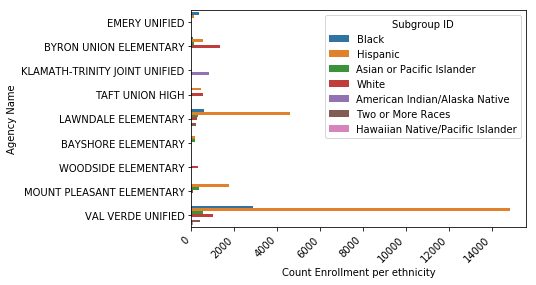

In [69]:
#Which is the ethnicity precence on each of these schools
plt.figure(figsize=(6, 4))
sns.barplot(x='Count Enrollment per ethnicity',y='Agency Name',hue='Subgroup ID',data=df_high_funding)
plt.xticks(rotation=45, ha='right')
plt.show()


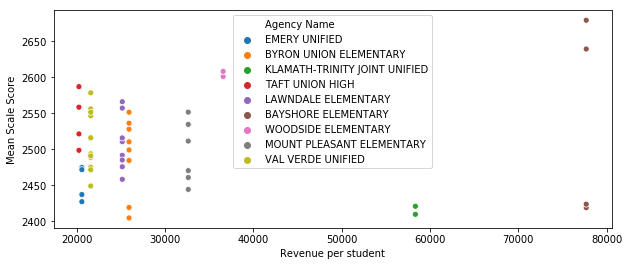

In [70]:
#We are looking at the schools and were are they in the revenue/score comparison
plt.figure(figsize=(10, 4))
sns.scatterplot(x='Revenue per student', y='Mean Scale Score', hue='Agency Name',data=df_high_funding)
plt.show()

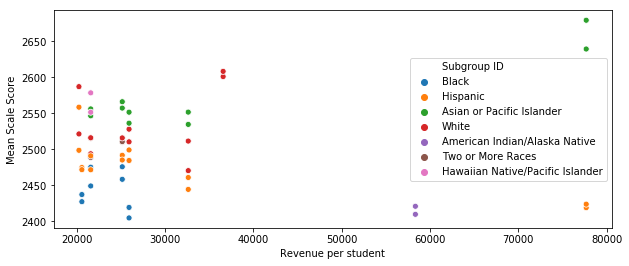

In [71]:
#Look at the ethnicities scores and were they are , see if there is any pattern.
plt.figure(figsize=(10, 4))
sns.scatterplot(x='Revenue per student', y='Mean Scale Score', hue='Subgroup ID',data=df_high_funding)
plt.show()

best fit line:
y = 2498.66 + 0.00x


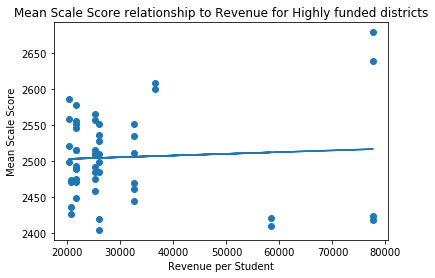

In [131]:
def best_fit(X, Y):

    xbar = sum(X)/len(X)
    ybar = sum(Y)/len(Y)
    n = len(X) # or len(Y)

    numer = sum([xi*yi for xi,yi in zip(X, Y)]) - n * xbar * ybar
    denum = sum([xi**2 for xi in X]) - n * xbar**2

    b = numer / denum
    a = ybar - b * xbar

    print('best fit line:\ny = {:.2f} + {:.2f}x'.format(a, b))

    return a, b
a, b = best_fit(df_high_funding['Revenue per student'],df_high_funding['Mean Scale Score'])
import matplotlib.pyplot as plt
plt.scatter(df_high_funding['Revenue per student'],df_high_funding['Mean Scale Score'])
yfit = [a + b * xi for xi in df_high_funding['Revenue per student']]
plt.plot(df_high_funding['Revenue per student'], yfit)
plt.title('Mean Scale Score relationship to Revenue for Highly funded districts')
plt.xlabel('Revenue per Student')
_=plt.ylabel('Mean Scale Score')

### When researched. Bayshore Elementary had a 5M revenue in 2020-2021 school year, so the total revenue in this dataset might have a typo or recording error. Bayshore Elementary has only 2 ethnicities recorded on the dataset were the scores for Hispanic Vs Asian are 200 points appart.

### Woodside Elementary has only white students, they have the second highest mean scores on this subset of the data.

### We can see that on this high revenue schools the renevue per student does not seem to have a high impact on scores. Scores go from lower to higher per ethnicity in the next order- Black , Hispanic, White, Asian or Pacific Islander, Hawaiian Native. It would be interesting to see the behavior on the other revenue groups.

In [107]:
# Checking what the dataset looks like now
df.shape

(7771, 27)

--------------------

# Dictrict size per enrollment

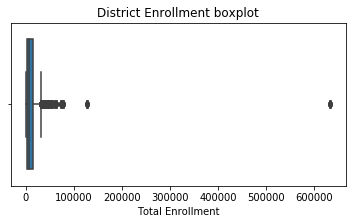

In [82]:
#Create a box plot to show the outliers on our data in regards of size.
plt.figure(figsize=(6,3))
sns.boxplot(df['Total Enrollment']),#orient='v')
plt.title('District Enrollment boxplot')
plt.show()

In [85]:
#We created 4 groups of districts by size of enrollment. 
large_districts_df = df[df['Total Enrollment'] >= 60_000]
medium_districts_df= df[(df['Total Enrollment'] < 60_000) & (df['Total Enrollment'] >= 30_000)]
small_districts_df = df[(df['Total Enrollment'] < 30_000) & (df['Total Enrollment'] >= 10_000)]
smaller_districts_df = df[(df['Total Enrollment'] < 10_000) & (df['Total Enrollment'] >= 5_000)]

## We will firts look at large districts, distribution of students by ethnicity, and understand if there is any pattern on grades by ethnicity

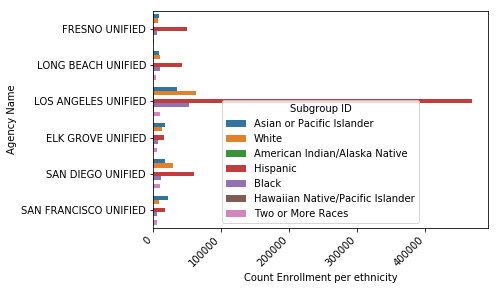

In [98]:
plt.figure(figsize=(6, 4))
sns.barplot(x='Count Enrollment per ethnicity',y='Agency Name',hue='Subgroup ID',data=large_districts_df)
plt.xticks(rotation=45, ha='right')
plt.show()


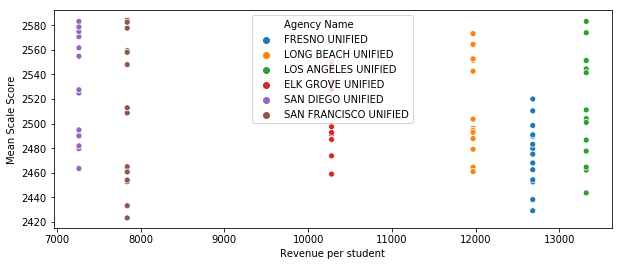

In [113]:
#We are looking at the schools and were are they in the revenue/score comparison
plt.figure(figsize=(10, 4))
sns.scatterplot(x='Revenue per student', y='Mean Scale Score', hue='Agency Name',data=large_districts_df)
plt.show()

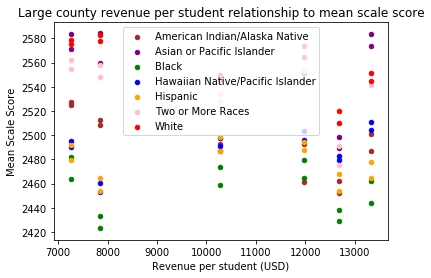

In [101]:
colors = {
    "Black": "green",
    "Hispanic": "orange",
    "White": "red",
    "Asian or Pacific Islander": "purple",
    "Hawaiian Native/Pacific Islander": "blue",
    'American Indian/Alaska Native':"brown",
    'Two or More Races':'pink'
}
_, ax = plt.subplots()
for key, group in large_districts_df.groupby("Subgroup ID"):
    group.plot.scatter(ax=ax, x="Revenue per student", y="Mean Scale Score", label=key, color=colors[key])
ax.set_xlabel("Revenue per student (USD)")
ax.set_ylabel("Mean Scale Score")
_ = ax.set_title(
    "Large county revenue per student relationship to mean scale score"
)

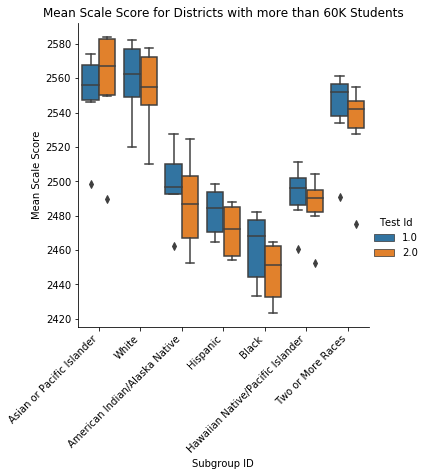

In [148]:
sns.catplot(x="Subgroup ID", y="Mean Scale Score", hue="Test Id", kind="box", data=large_districts_df)
plt.xticks(rotation=45, ha='right')
_=plt.title('Mean Scale Score for Districts with more than 60K Students')

In [105]:
ld_corr_df= large_districts_df.drop(columns=['District Code', 'Agency Name', 'Total Revenue',
       'Count Enrollment per ethnicity',
       'County Code', 'Test Id',
       'Total Tested At Entity Level', 'Total Tested with Scores',
       'CAASPP Reported Enrollment', 'Students Tested', 'Students with Scores',
       'Total Standard Exceeded', 'Total Standard Met',
       'Total Standard Met and Above', 'Total Standard Nearly Met',
       'Total Standard Not Met', 'Percentate Std Exceed', 'Percentage Std Met',
       'Percentage Std Nearly Met', 'Percentage Std Not Met',
       'Percentage Std Met and Above'])

In [106]:
ld_corr_df.corr()

,Total Enrollment,Revenue per student,Mean Scale Score,Pass,Fail
Total Enrollment,1.000000,0.486950,0.078305,0.087677,-0.079436
Revenue per student,0.486950,1.000000,-0.176964,-0.166037,0.166197
Mean Scale Score,0.078305,-0.176964,1.000000,0.978236,-0.978775
Pass,0.087677,-0.166037,0.978236,1.000000,-0.999393
Fail,-0.079436,0.166197,-0.978775,-0.999393,1.000000


In [ ]:
#Scatter plot for each ethnicity.
ld_asian_df = medium_districts_df[large_districts_df['Subgroup ID']=='Asian or Pacific Islander']
ld_black_df = medium_districts_df[large_districts_df['Subgroup ID']=='Black']
ld_amerindian_df = medium_districts_df[large_districts_df['Subgroup ID']=='American Indian/Alaska Native']
ld_hawaiian_df = medium_districts_df[large_districts_df['Subgroup ID']=='Hawaiian Native/Pacific Islander']
ld_two_df = medium_districts_df[large_districts_df['Subgroup ID']=='Black']
ld_hispanic_df = medium_districts_df[large_districts_df['Subgroup ID']=='Hispanic']
ld_white_df = medium_districts_df[large_districts_df['Subgroup ID']=='White']

In [ ]:
def best_fit(X, Y):

    xbar = sum(X)/len(X)
    ybar = sum(Y)/len(Y)
    n = len(X) # or len(Y)

    numer = sum([xi*yi for xi,yi in zip(X, Y)]) - n * xbar * ybar
    denum = sum([xi**2 for xi in X]) - n * xbar**2

    b = numer / denum
    a = ybar - b * xbar

    print('best fit line:\ny = {:.2f} + {:.2f}x'.format(a, b))

    return a, b
a, b = best_fit(ld_black_df['Revenue per student'],ld_black_df['Mean Scale Score'])
import matplotlib.pyplot as plt
plt.scatter(ld_black_df['Revenue per student'],ld_black_df['Mean Scale Score'])
yfit = [a + b * xi for xi in ld_black_df['Revenue per student']]
plt.plot(ld_black_df['Revenue per student'], yfit)
plt.xlabel('Revenue per Student')
plt.ylabel('Mean Scale Score')

best fit line:
y = 2628.07 + -0.01x


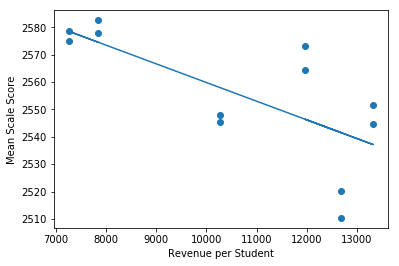

In [125]:
a, b = best_fit(ld_white_df['Revenue per student'],ld_white_df['Mean Scale Score'])
import matplotlib.pyplot as plt
plt.scatter(ld_white_df['Revenue per student'],ld_white_df['Mean Scale Score'])
yfit = [a + b * xi for xi in ld_white_df['Revenue per student']]
plt.plot(ld_white_df['Revenue per student'], yfit)
plt.xlabel('Revenue per Student')
_=plt.ylabel('Mean Scale Score')

In [132]:
white_corr_df= ld_white_df.drop(columns=['District Code', 'Agency Name', 'Total Revenue',
       'Count Enrollment per ethnicity',
       'County Code', 'Test Id',
       'Total Tested At Entity Level', 'Total Tested with Scores',
       'CAASPP Reported Enrollment', 'Students Tested', 'Students with Scores',
       'Total Standard Exceeded', 'Total Standard Met',
       'Total Standard Met and Above', 'Total Standard Nearly Met',
       'Total Standard Not Met', 'Percentate Std Exceed', 'Percentage Std Met',
       'Percentage Std Nearly Met', 'Percentage Std Not Met',
       'Percentage Std Met and Above'])
white_corr_df.corr()

,Total Enrollment,Revenue per student,Mean Scale Score,Pass,Fail
Total Enrollment,1.000000,0.486950,-0.121998,-0.068629,0.106480
Revenue per student,0.486950,1.000000,-0.703393,-0.603178,0.619094
Mean Scale Score,-0.121998,-0.703393,1.000000,0.942396,-0.941844
Pass,-0.068629,-0.603178,0.942396,1.000000,-0.998064
Fail,0.106480,0.619094,-0.941844,-0.998064,1.000000


best fit line:
y = 2481.76 + -0.00x


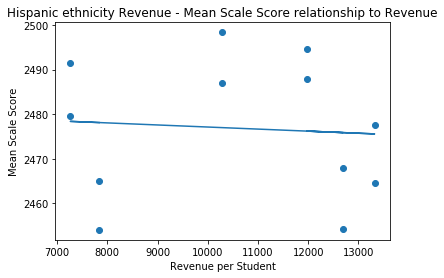

In [129]:
a, b = best_fit(ld_hispanic_df['Revenue per student'],ld_hispanic_df['Mean Scale Score'])
import matplotlib.pyplot as plt
plt.scatter(ld_hispanic_df['Revenue per student'],ld_hispanic_df['Mean Scale Score'])
yfit = [a + b * xi for xi in ld_hispanic_df['Revenue per student']]
plt.plot(ld_hispanic_df['Revenue per student'], yfit)
plt.title('Hispanic ethnicity Revenue - Mean Scale Score relationship to Revenue')
plt.xlabel('Revenue per Student')
_=plt.ylabel('Mean Scale Score')

best fit line:
y = 2613.54 + -0.01x


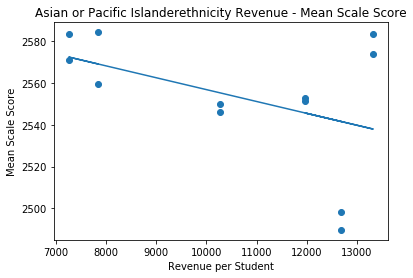

In [120]:
a, b = best_fit(ld_asian_df['Revenue per student'],ld_asian_df['Mean Scale Score'])
import matplotlib.pyplot as plt
plt.scatter(ld_asian_df['Revenue per student'],ld_asian_df['Mean Scale Score'])
yfit = [a + b * xi for xi in ld_asian_df['Revenue per student']]
plt.plot(ld_asian_df['Revenue per student'], yfit)
plt.title('Asian or Pacific Islander ethnicity Revenue - Mean Scale Score relationship to Revenu')
plt.xlabel('Revenue per Student')
_=plt.ylabel('Mean Scale Score')

In [134]:
asian_corr_df= ld_asian_df.drop(columns=['District Code', 'Agency Name', 'Total Revenue',
       'Count Enrollment per ethnicity',
       'County Code', 'Test Id',
       'Total Tested At Entity Level', 'Total Tested with Scores',
       'CAASPP Reported Enrollment', 'Students Tested', 'Students with Scores',
       'Total Standard Exceeded', 'Total Standard Met',
       'Total Standard Met and Above', 'Total Standard Nearly Met',
       'Total Standard Not Met', 'Percentate Std Exceed', 'Percentage Std Met',
       'Percentage Std Nearly Met', 'Percentage Std Not Met',
       'Percentage Std Met and Above'])
asian_corr_df.corr()

,Total Enrollment,Revenue per student,Mean Scale Score,Pass,Fail
Total Enrollment,1.000000,0.486950,0.407549,0.374619,-0.379776
Revenue per student,0.486950,1.000000,-0.444055,-0.441821,0.433511
Mean Scale Score,0.407549,-0.444055,1.000000,0.948042,-0.943552
Pass,0.374619,-0.441821,0.948042,1.000000,-0.999504
Fail,-0.379776,0.433511,-0.943552,-0.999504,1.000000


best fit line:
y = 2574.77 + -0.01x


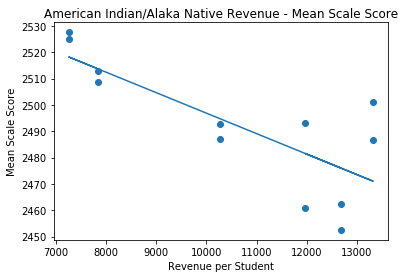

In [126]:
a, b = best_fit(ld_amerindian_df['Revenue per student'],ld_amerindian_df['Mean Scale Score'])
import matplotlib.pyplot as plt
plt.scatter(ld_amerindian_df['Revenue per student'],ld_amerindian_df['Mean Scale Score'])
yfit = [a + b * xi for xi in ld_amerindian_df['Revenue per student']]
plt.plot(ld_amerindian_df['Revenue per student'], yfit)
plt.title('American Indian/Alaka Native Revenue - Mean Scale Score relationship to Revenue')
plt.xlabel('Revenue per Student')
_=plt.ylabel('Mean Scale Score')

In [135]:
amerindian_corr_df= ld_amerindian_df.drop(columns=['District Code', 'Agency Name', 'Total Revenue',
       'Count Enrollment per ethnicity',
       'County Code', 'Test Id',
       'Total Tested At Entity Level', 'Total Tested with Scores',
       'CAASPP Reported Enrollment', 'Students Tested', 'Students with Scores',
       'Total Standard Exceeded', 'Total Standard Met',
       'Total Standard Met and Above', 'Total Standard Nearly Met',
       'Total Standard Not Met', 'Percentate Std Exceed', 'Percentage Std Met',
       'Percentage Std Nearly Met', 'Percentage Std Not Met',
       'Percentage Std Met and Above'])
amerindian_corr_df.corr()

,Total Enrollment,Revenue per student,Mean Scale Score,Pass,Fail
Total Enrollment,1.000000,0.486950,0.078294,0.171309,-0.133023
Revenue per student,0.486950,1.000000,-0.773371,-0.638905,0.661424
Mean Scale Score,0.078294,-0.773371,1.000000,0.897066,-0.904262
Pass,0.171309,-0.638905,0.897066,1.000000,-0.997844
Fail,-0.133023,0.661424,-0.904262,-0.997844,1.000000


In [ ]:
white_corr_df= ld_white_df.drop(columns=['District Code', 'Agency Name', 'Total Revenue',
       'Count Enrollment per ethnicity',
       'County Code', 'Test Id',
       'Total Tested At Entity Level', 'Total Tested with Scores',
       'CAASPP Reported Enrollment', 'Students Tested', 'Students with Scores',
       'Total Standard Exceeded', 'Total Standard Met',
       'Total Standard Met and Above', 'Total Standard Nearly Met',
       'Total Standard Not Met', 'Percentate Std Exceed', 'Percentage Std Met',
       'Percentage Std Nearly Met', 'Percentage Std Not Met',
       'Percentage Std Met and Above'])
white_corr_df.corr()

best fit line:
y = 2459.47 + -0.00x


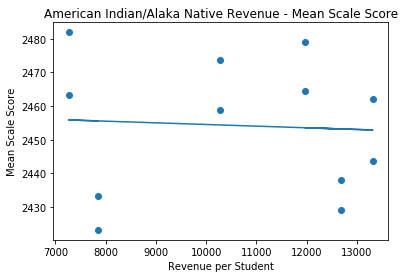

In [127]:
a, b = best_fit(ld_two_df['Revenue per student'],ld_two_df['Mean Scale Score'])
import matplotlib.pyplot as plt
plt.scatter(ld_two_df['Revenue per student'],ld_two_df['Mean Scale Score'])
yfit = [a + b * xi for xi in ld_two_df['Revenue per student']]
plt.plot(ld_two_df['Revenue per student'], yfit)
plt.title('Two or more races - Mean Scale Score relationship to Revenue')
plt.xlabel('Revenue per Student')
_=plt.ylabel('Mean Scale Score')

### It seems that revenue per student has a negative correlation to Mean Scale score or students passing. As we noted on each of the different ethnicities it would seem the larger the revenue per student the lower test scores, whith the highest impact on ethnicities - American Indian/Alaska Native, White and Asian or Pacific Islander.

# Medium size Districts analysis

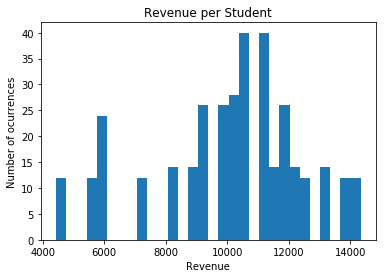

In [140]:
_ = plt.hist(medium_districts_df['Revenue per student'], density=False, bins=30)
_ = plt.ylabel('Number of ocurrences')
_ = plt.xlabel('Revenue')
_ = plt.title("Revenue per Student")

### FIND SOME BETTER WAY TO SHOW THIS

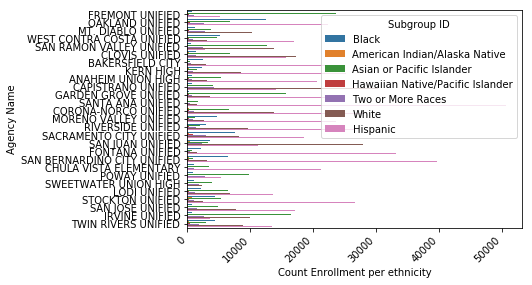

In [156]:
#Which is the ethnicity precence on each of these schools
plt.figure(figsize=(6, 4))
sns.barplot(x='Count Enrollment per ethnicity',y='Agency Name',hue='Subgroup ID',data=medium_districts_df)
plt.xticks(rotation=45, ha='right')
plt.show()

best fit line:
y = 2615.06 + -0.01x


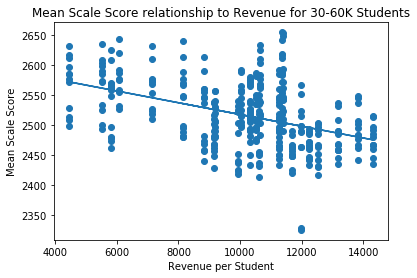

In [144]:
a, b = best_fit(medium_districts_df['Revenue per student'],medium_districts_df['Mean Scale Score'])
import matplotlib.pyplot as plt
plt.scatter(medium_districts_df['Revenue per student'],medium_districts_df['Mean Scale Score'])
yfit = [a + b * xi for xi in medium_districts_df['Revenue per student']]
plt.plot(medium_districts_df['Revenue per student'], yfit)
plt.title('Mean Scale Score relationship to Revenue for 30-60K Students')
plt.xlabel('Revenue per Student')
_=plt.ylabel('Mean Scale Score')

In [145]:
medium_corr_df= medium_districts_df.drop(columns=['District Code', 'Agency Name', 'Total Revenue',
       'Count Enrollment per ethnicity',
       'County Code', 'Test Id',
       'Total Tested At Entity Level', 'Total Tested with Scores',
       'CAASPP Reported Enrollment', 'Students Tested', 'Students with Scores',
       'Total Standard Exceeded', 'Total Standard Met',
       'Total Standard Met and Above', 'Total Standard Nearly Met',
       'Total Standard Not Met', 'Percentate Std Exceed', 'Percentage Std Met',
       'Percentage Std Nearly Met', 'Percentage Std Not Met',
       'Percentage Std Met and Above'])
medium_corr_df.corr()

,Total Enrollment,Revenue per student,Mean Scale Score,Pass,Fail
Total Enrollment,1.000000,0.096638,-0.063949,-0.023281,0.023393
Revenue per student,0.096638,1.000000,-0.432554,-0.478455,0.479859
Mean Scale Score,-0.063949,-0.432554,1.000000,0.873283,-0.873767
Pass,-0.023281,-0.478455,0.873283,1.000000,-0.999350
Fail,0.023393,0.479859,-0.873767,-0.999350,1.000000


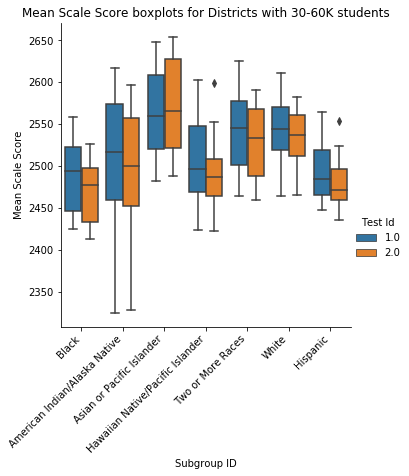

In [147]:
sns.catplot(x="Subgroup ID", y="Mean Scale Score", hue="Test Id", kind="box", data=medium_districts_df)
plt.xticks(rotation=45, ha='right')
_=plt.title('Mean Scale Score boxplots for Districts with 30-60K students')

### We continue to see the negative correlation to Revenue per student on this size districts - 30-60K students. 

### We see also that the difference in mean scale scores reduces between ethnicities for these districts, which in the larger districts we saw a larger difference between them on results.

# Small Districts Analysis

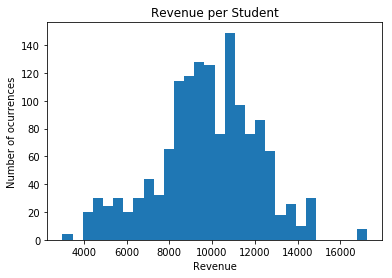

In [157]:
_ = plt.hist(small_districts_df['Revenue per student'], density=False, bins=30)
_ = plt.ylabel('Number of ocurrences')
_ = plt.xlabel('Revenue')
_ = plt.title("Revenue per Student - Districts with 10-30K students")

best fit line:
y = 2605.37 + -0.01x


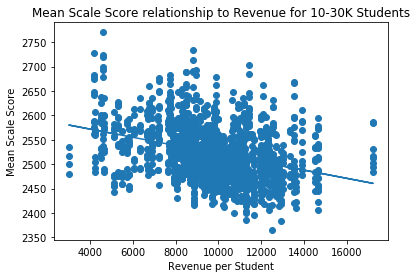

In [158]:
a, b = best_fit(small_districts_df['Revenue per student'],small_districts_df['Mean Scale Score'])
import matplotlib.pyplot as plt
plt.scatter(small_districts_df['Revenue per student'],small_districts_df['Mean Scale Score'])
yfit = [a + b * xi for xi in small_districts_df['Revenue per student']]
plt.plot(small_districts_df['Revenue per student'], yfit)
plt.title('Mean Scale Score relationship to Revenue for 10-30K Students')
plt.xlabel('Revenue per Student')
_=plt.ylabel('Mean Scale Score')

In [159]:
small_corr_df= small_districts_df.drop(columns=['District Code', 'Agency Name', 'Total Revenue',
       'Count Enrollment per ethnicity',
       'County Code', 'Test Id',
       'Total Tested At Entity Level', 'Total Tested with Scores',
       'CAASPP Reported Enrollment', 'Students Tested', 'Students with Scores',
       'Total Standard Exceeded', 'Total Standard Met',
       'Total Standard Met and Above', 'Total Standard Nearly Met',
       'Total Standard Not Met', 'Percentate Std Exceed', 'Percentage Std Met',
       'Percentage Std Nearly Met', 'Percentage Std Not Met',
       'Percentage Std Met and Above'])
small_corr_df.corr()

,Total Enrollment,Revenue per student,Mean Scale Score,Pass,Fail
Total Enrollment,1.000000,0.137482,0.018621,-0.005921,0.005617
Revenue per student,0.137482,1.000000,-0.337870,-0.319106,0.319305
Mean Scale Score,0.018621,-0.337870,1.000000,0.846134,-0.846327
Pass,-0.005921,-0.319106,0.846134,1.000000,-0.999568
Fail,0.005617,0.319305,-0.846327,-0.999568,1.000000


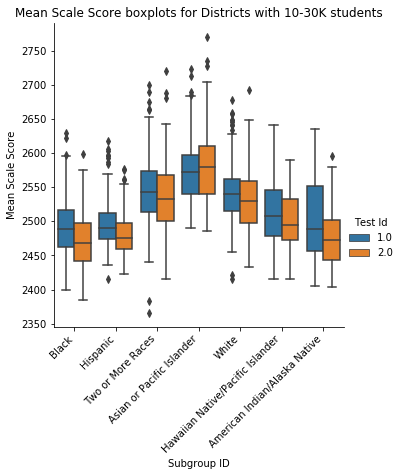

In [160]:
sns.catplot(x="Subgroup ID", y="Mean Scale Score", hue="Test Id", kind="box", data=small_districts_df)
plt.xticks(rotation=45, ha='right')
_=plt.title('Mean Scale Score boxplots for Districts with 10-30K students')

### The downward slope and negative correlation continue to appear on these size districts 10-30 K students. Looking at the mean scores and the difference between ethnicities, we want to evaluate the enrollment size against mean scores and studdents passing, which seems the larger the group the lower the scores.

best fit line:
y = 2519.80 + 0.00x


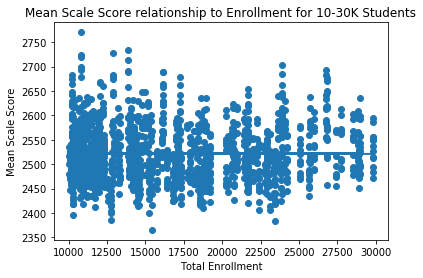

In [207]:
a, b = best_fit(small_districts_df['Total Enrollment'],small_districts_df['Mean Scale Score'])
import matplotlib.pyplot as plt
plt.scatter(small_districts_df['Total Enrollment'],small_districts_df['Mean Scale Score'])
yfit = [a + b * xi for xi in small_districts_df['Revenue per student']]
plt.plot(small_districts_df['Total Enrollment'], yfit)
plt.title('Mean Scale Score relationship to Enrollment for 10-30K Students')
plt.xlabel('Total Enrollment')
_=plt.ylabel('Mean Scale Score')

In [164]:
asian_df = df[df['Subgroup ID']=='Asian or Pacific Islander']
black_df = df[df['Subgroup ID']=='Black']
amerindian_df = df[df['Subgroup ID']=='American Indian/Alaska Native']
hawaiian_df = df[df['Subgroup ID']=='Hawaiian Native/Pacific Islander']
two_df = df[df['Subgroup ID']=='Black']
hispanic_df = df[df['Subgroup ID']=='Hispanic']
white_df = df[df['Subgroup ID']=='White']

In [163]:
#Scatter plot for each ethnicity.
md_asian_df = medium_districts_df[medium_districts_df['Subgroup ID']=='Asian or Pacific Islander']
md_black_df = medium_districts_df[medium_districts_df['Subgroup ID']=='Black']
md_amerindian_df = medium_districts_df[medium_districts_df['Subgroup ID']=='American Indian/Alaska Native']
md_hawaiian_df = medium_districts_df[medium_districts_df['Subgroup ID']=='Hawaiian Native/Pacific Islander']
md_two_df = medium_districts_df[medium_districts_df['Subgroup ID']=='Black']
md_hispanic_df = medium_districts_df[medium_districts_df['Subgroup ID']=='Hispanic']
md_white_df = medium_districts_df[medium_districts_df['Subgroup ID']=='White']
sd_asian_df = small_districts_df[small_districts_df['Subgroup ID']=='Asian or Pacific Islander']
sd_black_df = small_districts_df[small_districts_df['Subgroup ID']=='Black']
sd_amerindian_df = small_districts_df[small_districts_df['Subgroup ID']=='American Indian/Alaska Native']
sd_hawaiian_df = small_districts_df[small_districts_df['Subgroup ID']=='Hawaiian Native/Pacific Islander']
sd_two_df = small_districts_df[small_districts_df['Subgroup ID']=='Black']
sd_hispanic_df = small_districts_df[small_districts_df['Subgroup ID']=='Hispanic']
sd_white_df = small_districts_df[small_districts_df['Subgroup ID']=='White']

In [165]:
asian_corr_df= asian_df.drop(columns=['District Code', 'Agency Name', 'Total Revenue',
       'County Code', 'Test Id',
       'Total Tested At Entity Level', 'Total Tested with Scores',
       'CAASPP Reported Enrollment', 'Students Tested', 'Students with Scores',
       'Total Standard Exceeded', 'Total Standard Met',
       'Total Standard Met and Above', 'Total Standard Nearly Met',
       'Total Standard Not Met', 'Percentate Std Exceed', 'Percentage Std Met',
       'Percentage Std Nearly Met', 'Percentage Std Not Met',
       'Percentage Std Met and Above'])
asian_corr_df.corr()

,Total Enrollment,Revenue per student,Count Enrollment per ethnicity,Mean Scale Score,Pass,Fail
Total Enrollment,1.000000,0.111988,0.673853,-0.004071,-0.017195,0.014992
Revenue per student,0.111988,1.000000,-0.067066,-0.424320,-0.468774,0.469253
Count Enrollment per ethnicity,0.673853,-0.067066,1.000000,0.127107,0.137542,-0.139469
Mean Scale Score,-0.004071,-0.424320,0.127107,1.000000,0.743201,-0.742662
Pass,-0.017195,-0.468774,0.137542,0.743201,1.000000,-0.999486
Fail,0.014992,0.469253,-0.139469,-0.742662,-0.999486,1.000000


best fit line:
y = 2544.53 + 0.00x


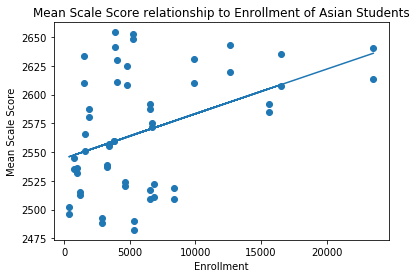

In [217]:
#We see a positive correllation on the enrollment per ethnicity on the specific ethnicity
a, b = best_fit(md_asian_df['Count Enrollment per ethnicity'],md_asian_df['Mean Scale Score'])
import matplotlib.pyplot as plt
plt.scatter(md_asian_df['Count Enrollment per ethnicity'],md_asian_df['Mean Scale Score'])
yfit = [a + b * xi for xi in md_asian_df['Count Enrollment per ethnicity']]
plt.plot(md_asian_df['Count Enrollment per ethnicity'], yfit)
plt.title('Mean Scale Score relationship to Enrollment of Asian Students')
plt.xlabel('Enrollment')
_=plt.ylabel('Mean Scale Score')

best fit line:
y = 2524.42 + 0.00x


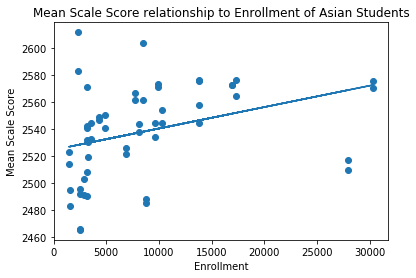

In [221]:
#We see a positive correllation on the enrollment per ethnicity on the specific ethnicity
a, b = best_fit(md_white_df['Count Enrollment per ethnicity'],md_white_df['Mean Scale Score'])
import matplotlib.pyplot as plt
plt.scatter(md_white_df['Count Enrollment per ethnicity'],md_white_df['Mean Scale Score'])
yfit = [a + b * xi for xi in md_white_df['Count Enrollment per ethnicity']]
plt.plot(md_white_df['Count Enrollment per ethnicity'], yfit)
plt.title('Mean Scale Score relationship to Enrollment of Asian Students')
plt.xlabel('Enrollment')
_=plt.ylabel('Mean Scale Score')

In [176]:
black_corr_df= black_df.drop(columns=['District Code', 'Agency Name', 'Total Revenue',
       'County Code', 'Test Id',
       'Total Tested At Entity Level', 'Total Tested with Scores',
       'CAASPP Reported Enrollment', 'Students Tested', 'Students with Scores',
       'Total Standard Exceeded', 'Total Standard Met',
       'Total Standard Met and Above', 'Total Standard Nearly Met',
       'Total Standard Not Met', 'Percentate Std Exceed', 'Percentage Std Met',
       'Percentage Std Nearly Met', 'Percentage Std Not Met',
       'Percentage Std Met and Above'])
black_corr_df.corr()

,Total Enrollment,Revenue per student,Count Enrollment per ethnicity,Mean Scale Score,Pass,Fail
Total Enrollment,1.000000,0.081148,0.945347,-0.059922,-0.057697,0.059321
Revenue per student,0.081148,1.000000,0.163394,-0.410312,-0.384782,0.384248
Count Enrollment per ethnicity,0.945347,0.163394,1.000000,-0.160364,-0.151041,0.152240
Mean Scale Score,-0.059922,-0.410312,-0.160364,1.000000,0.776081,-0.777349
Pass,-0.057697,-0.384782,-0.151041,0.776081,1.000000,-0.999044
Fail,0.059321,0.384248,0.152240,-0.777349,-0.999044,1.000000


best fit line:
y = 2501.07 + -0.01x


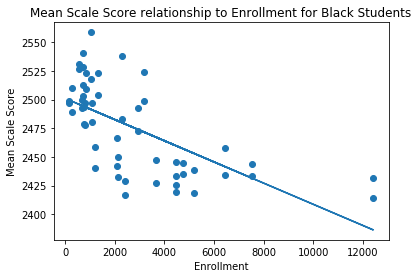

In [208]:
a, b = best_fit(md_black_df['Count Enrollment per ethnicity'],md_black_df['Mean Scale Score'])
import matplotlib.pyplot as plt
plt.scatter(md_black_df['Count Enrollment per ethnicity'],md_black_df['Mean Scale Score'])
yfit = [a + b * xi for xi in md_black_df['Count Enrollment per ethnicity']]
plt.plot(md_black_df['Count Enrollment per ethnicity'], yfit)
plt.title('Mean Scale Score relationship to Enrollment for Black Students')
plt.xlabel('Enrollment')
_=plt.ylabel('Mean Scale Score')

best fit line:
y = 2504.81 + -0.00x


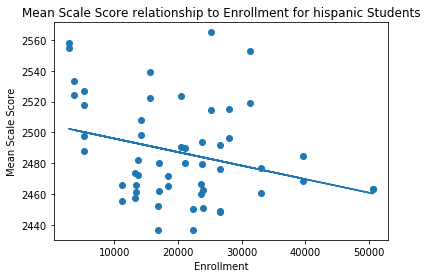

In [216]:
a, b = best_fit(md_hispanic_df['Count Enrollment per ethnicity'],md_hispanic_df['Mean Scale Score'])
import matplotlib.pyplot as plt
plt.scatter(md_hispanic_df['Count Enrollment per ethnicity'],md_hispanic_df['Mean Scale Score'])
yfit = [a + b * xi for xi in md_hispanic_df['Count Enrollment per ethnicity']]
plt.plot(md_hispanic_df['Count Enrollment per ethnicity'], yfit)
plt.title('Mean Scale Score relationship to Enrollment for hispanic Students')
plt.xlabel('Enrollment')
_=plt.ylabel('Mean Scale Score')

### We can see how on smaller enrollment the scores seem to increase. For black and hispanic students.

# Smaller Districts Analysis

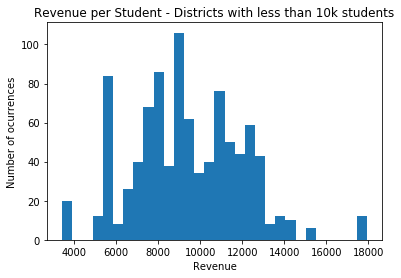

In [187]:
_ = plt.hist(smaller_districts_df['Revenue per student'], density=False, bins=30)
_ = plt.ylabel('Number of ocurrences')
_ = plt.xlabel('Revenue')
_ = plt.title("Revenue per Student - Districts with less than 10k students")

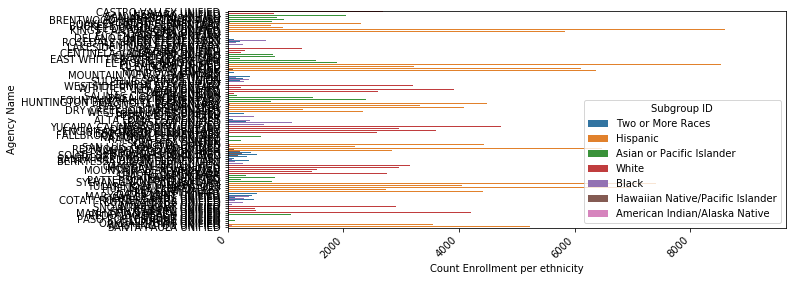

In [182]:
#Which is the ethnicity precence on each of these schools
plt.figure(figsize=(10, 4))
sns.barplot(x='Count Enrollment per ethnicity',y='Agency Name',hue='Subgroup ID',data=smaller_districts_df)
plt.xticks(rotation=45, ha='right')
plt.show()

In [183]:
smaller_corr_df= smaller_districts_df.drop(columns=['District Code', 'Agency Name', 'Total Revenue',
       'Count Enrollment per ethnicity',
       'County Code', 'Test Id',
       'Total Tested At Entity Level', 'Total Tested with Scores',
       'CAASPP Reported Enrollment', 'Students Tested', 'Students with Scores',
       'Total Standard Exceeded', 'Total Standard Met',
       'Total Standard Met and Above', 'Total Standard Nearly Met',
       'Total Standard Not Met', 'Percentate Std Exceed', 'Percentage Std Met',
       'Percentage Std Nearly Met', 'Percentage Std Not Met',
       'Percentage Std Met and Above'])
smaller_corr_df.corr()

,Total Enrollment,Revenue per student,Mean Scale Score,Pass,Fail
Total Enrollment,1.000000,0.024251,0.015964,-0.059170,0.058415
Revenue per student,0.024251,1.000000,-0.351207,-0.325845,0.324299
Mean Scale Score,0.015964,-0.351207,1.000000,0.795174,-0.794743
Pass,-0.059170,-0.325845,0.795174,1.000000,-0.999597
Fail,0.058415,0.324299,-0.794743,-0.999597,1.000000


best fit line:
y = 2605.32 + -0.01x


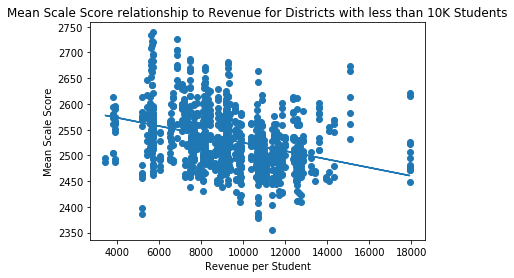

In [192]:
a, b = best_fit(smaller_districts_df['Revenue per student'],smaller_districts_df['Mean Scale Score'])
import matplotlib.pyplot as plt
plt.scatter(smaller_districts_df['Revenue per student'],smaller_districts_df['Mean Scale Score'])
yfit = [a + b * xi for xi in smaller_districts_df['Revenue per student']]
plt.plot(smaller_districts_df['Revenue per student'], yfit)
plt.title('Mean Scale Score relationship to Revenue for Districts with less than 10K Students')
plt.xlabel('Revenue per Student')
_=plt.ylabel('Mean Scale Score')

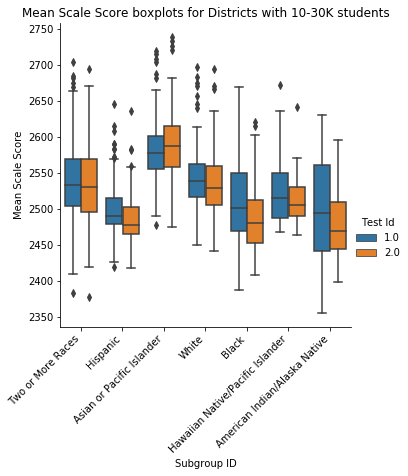

In [185]:
sns.catplot(x="Subgroup ID", y="Mean Scale Score", hue="Test Id", kind="box", data=smaller_districts_df)
plt.xticks(rotation=45, ha='right')
_=plt.title('Mean Scale Score boxplots for Districts with les 10K students')

best fit line:
y = 2507.55 + -0.00x


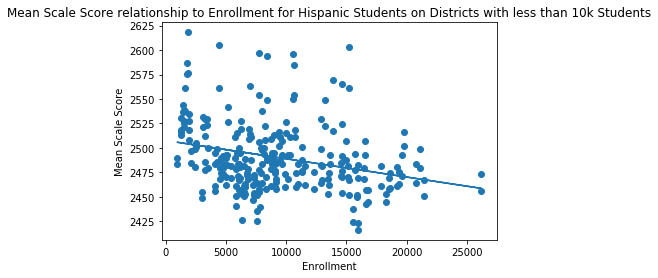

In [211]:
a, b = best_fit(sd_hispanic_df['Count Enrollment per ethnicity'],sd_hispanic_df['Mean Scale Score'])
import matplotlib.pyplot as plt
plt.scatter(sd_hispanic_df['Count Enrollment per ethnicity'],sd_hispanic_df['Mean Scale Score'])
yfit = [a + b * xi for xi in sd_hispanic_df['Count Enrollment per ethnicity']]
plt.plot(sd_hispanic_df['Count Enrollment per ethnicity'], yfit)
plt.title('Mean Scale Score relationship to Enrollment for Hispanic Students on Districts with less than 10k Students')
plt.xlabel('Enrollment')
_=plt.ylabel('Mean Scale Score')

In [188]:
srd_black_df = smaller_districts_df[smaller_districts_df['Subgroup ID']=='Black']
black_srd_corr_df= srd_black_df.drop(columns=['District Code', 'Agency Name', 'Total Revenue',
       'County Code', 'Test Id',
       'Total Tested At Entity Level', 'Total Tested with Scores',
       'CAASPP Reported Enrollment', 'Students Tested', 'Students with Scores',
       'Total Standard Exceeded', 'Total Standard Met',
       'Total Standard Met and Above', 'Total Standard Nearly Met',
       'Total Standard Not Met', 'Percentate Std Exceed', 'Percentage Std Met',
       'Percentage Std Nearly Met', 'Percentage Std Not Met',
       'Percentage Std Met and Above'])
black_srd_corr_df.corr()

,Total Enrollment,Revenue per student,Count Enrollment per ethnicity,Mean Scale Score,Pass,Fail
Total Enrollment,1.000000,-0.055680,0.223329,-0.060393,-0.130102,0.133682
Revenue per student,-0.055680,1.000000,0.417191,-0.473188,-0.383615,0.382393
Count Enrollment per ethnicity,0.223329,0.417191,1.000000,-0.329409,-0.313524,0.314598
Mean Scale Score,-0.060393,-0.473188,-0.329409,1.000000,0.763634,-0.764028
Pass,-0.130102,-0.383615,-0.313524,0.763634,1.000000,-0.999403
Fail,0.133682,0.382393,0.314598,-0.764028,-0.999403,1.000000


## Tiny districts: between 1,000 and 5,000 total enrollment

In [194]:
tiny_districts =df[(df['Total Enrollment'] < 5_000) & (df['Total Enrollment'] >= 1000)]
tiny_districts.head(5)

,District Code,Agency Name,Total Enrollment,Total Revenue,Revenue per student,Subgroup ID,Count Enrollment per ethnicity,County Code,Test Id,Mean Scale Score,...,Total Standard Met and Above,Total Standard Nearly Met,Total Standard Not Met,Percentate Std Exceed,Percentage Std Met,Percentage Std Nearly Met,Percentage Std Not Met,Percentage Std Met and Above,Pass,Fail
1270,61127,ALBANY CITY UNIFIED,3702.0,58211000.0,15724.2,Hispanic,603.0,1.0,1.0,2549.028571,...,206.0,61.0,44.0,26.0,40.0,20.0,14.0,66.0,66.0,34.0
1269,61127,ALBANY CITY UNIFIED,3702.0,58211000.0,15724.2,Hispanic,603.0,1.0,2.0,2544.714286,...,179.0,80.0,55.0,27.0,30.0,25.0,18.0,57.0,57.0,43.0
2977,61127,ALBANY CITY UNIFIED,3702.0,58211000.0,15724.2,White,1368.0,1.0,2.0,2599.357143,...,586.0,101.0,51.0,51.0,28.0,14.0,7.0,79.0,79.0,21.0
2978,61127,ALBANY CITY UNIFIED,3702.0,58211000.0,15724.2,White,1368.0,1.0,1.0,2599.485714,...,631.0,75.0,39.0,53.0,32.0,10.0,5.0,85.0,85.0,15.0
4680,61127,ALBANY CITY UNIFIED,3702.0,58211000.0,15724.2,Asian or Pacific Islander,1080.0,1.0,1.0,2591.914286,...,422.0,58.0,29.0,47.0,36.0,11.0,6.0,83.0,83.0,17.0


In [203]:
# correlation between the variables
corr= tiny_districts.drop(columns=['District Code', 'Agency Name', 'Total Revenue',
       'County Code', 'Test Id',
       'Total Tested At Entity Level', 'Total Tested with Scores',
       'CAASPP Reported Enrollment', 'Students Tested', 'Students with Scores',
       'Total Standard Exceeded', 'Total Standard Met',
       'Total Standard Met and Above', 'Total Standard Nearly Met',
       'Total Standard Not Met', 'Percentate Std Exceed', 'Percentage Std Met',
       'Percentage Std Nearly Met', 'Percentage Std Not Met',
       'Percentage Std Met and Above'])
corr=corr.corr()
corr.style.background_gradient(cmap='coolwarm')
# 'RdBu_r' & 'BrBG' are other good diverging colormaps

,Total Enrollment,Revenue per student,Count Enrollment per ethnicity,Mean Scale Score,Pass,Fail
Total Enrollment,1,0.005374,0.279238,0.114686,0.138053,-0.136894
Revenue per student,0.005374,1,0.0688062,-0.295658,-0.317445,0.317938
Count Enrollment per ethnicity,0.279238,0.0688062,1,-0.0719394,-0.0991922,0.101063
Mean Scale Score,0.114686,-0.295658,-0.0719394,1,0.827844,-0.828161
Pass,0.138053,-0.317445,-0.0991922,0.827844,1,-0.999585
Fail,-0.136894,0.317938,0.101063,-0.828161,-0.999585,1


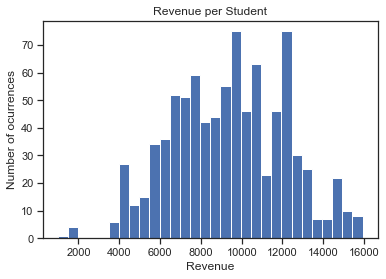

In [40]:
_ = plt.hist(tiny_districts_ID1['Revenue per student'], density=False, bins=30)
_ = plt.ylabel('Number of ocurrences')
_ = plt.xlabel('Revenue')
_ = plt.title("Revenue per Student")

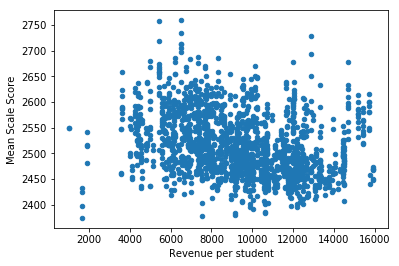

In [196]:
scatterplot1 = tiny_districts[['Revenue per student', 'Mean Scale Score']]
scatterplot1
scatterplot1.plot.scatter(x='Revenue per student', y='Mean Scale Score')

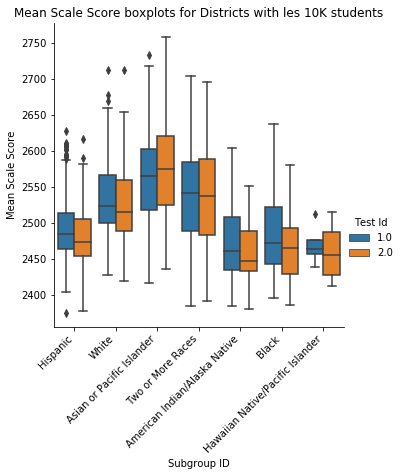

In [214]:
sns.catplot(x="Subgroup ID", y="Mean Scale Score", hue="Test Id", kind="box", data=tiny_districts)
plt.xticks(rotation=45, ha='right')
_=plt.title('Mean Scale Score boxplots for Districts with les 10K students')

In [ ]:
#_ = sns.catplot(x='Mean Scale Score', y="Revenue per student", hue="Subgroup ID", kind="swarm", data=tiny_districts_ID1)

## Mini districts: total enrollment less than 1,000

In [197]:
mini_districts = df[(df['Total Enrollment'] < 1000)]
print(mini_districts.shape)

mini_districts.head(5)

(593, 27)


,District Code,Agency Name,Total Enrollment,Total Revenue,Revenue per student,Subgroup ID,Count Enrollment per ethnicity,County Code,Test Id,Mean Scale Score,...,Total Standard Met and Above,Total Standard Nearly Met,Total Standard Not Met,Percentate Std Exceed,Percentage Std Met,Percentage Std Nearly Met,Percentage Std Not Met,Percentage Std Met and Above,Pass,Fail
3099,61408,BIGGS UNIFIED,617.0,6067000.0,9833.06,White,348.0,4.0,1.0,2482.842857,...,61.0,35.0,54.0,13.0,27.0,23.0,36.0,41.0,40.0,59.0
1389,61408,BIGGS UNIFIED,617.0,6067000.0,9833.06,Hispanic,231.0,4.0,1.0,2442.883333,...,21.0,34.0,59.0,4.0,14.0,30.0,52.0,18.0,18.0,82.0
1388,61408,BIGGS UNIFIED,617.0,6067000.0,9833.06,Hispanic,231.0,4.0,2.0,2441.466667,...,12.0,34.0,69.0,1.0,10.0,30.0,60.0,10.0,11.0,90.0
3098,61408,BIGGS UNIFIED,617.0,6067000.0,9833.06,White,348.0,4.0,2.0,2463.171429,...,30.0,49.0,73.0,3.0,16.0,32.0,48.0,20.0,19.0,80.0
3359,61432,DURHAM UNIFIED,985.0,7402000.0,7514.72,White,725.0,4.0,2.0,2538.157143,...,183.0,109.0,71.0,22.0,29.0,30.0,20.0,50.0,51.0,50.0


In [204]:
# correlation between the variables
corr1tiny = tiny_districts.drop(columns=['District Code', 'Agency Name', 'Total Revenue',
       'County Code', 'Test Id',
       'Total Tested At Entity Level', 'Total Tested with Scores',
       'CAASPP Reported Enrollment', 'Students Tested', 'Students with Scores',
       'Total Standard Exceeded', 'Total Standard Met',
       'Total Standard Met and Above', 'Total Standard Nearly Met',
       'Total Standard Not Met', 'Percentate Std Exceed', 'Percentage Std Met',
       'Percentage Std Nearly Met', 'Percentage Std Not Met',
       'Percentage Std Met and Above'])
corr1tiny=corr1tiny.corr()
corr1tiny.style.background_gradient(cmap='coolwarm')
# 'RdBu_r' & 'BrBG' are other good diverging colormaps

,Total Enrollment,Revenue per student,Count Enrollment per ethnicity,Mean Scale Score,Pass,Fail
Total Enrollment,1,0.005374,0.279238,0.114686,0.138053,-0.136894
Revenue per student,0.005374,1,0.0688062,-0.295658,-0.317445,0.317938
Count Enrollment per ethnicity,0.279238,0.0688062,1,-0.0719394,-0.0991922,0.101063
Mean Scale Score,0.114686,-0.295658,-0.0719394,1,0.827844,-0.828161
Pass,0.138053,-0.317445,-0.0991922,0.827844,1,-0.999585
Fail,-0.136894,0.317938,0.101063,-0.828161,-0.999585,1


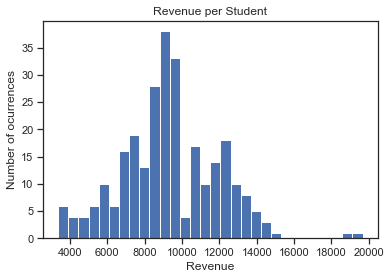

In [53]:
_ = plt.hist(mini_districts_ID1['Revenue per student'], density=False, bins=30)
_ = plt.ylabel('Number of ocurrences')
_ = plt.xlabel('Revenue')
_ = plt.title("Revenue per Student")

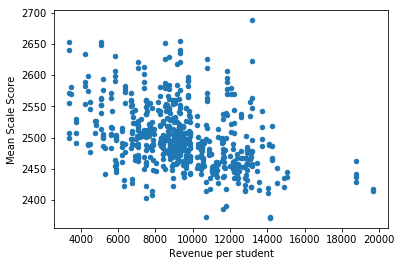

In [205]:
scatterplot1 = mini_districts[['Revenue per student', 'Mean Scale Score']]
scatterplot1
scatterplot1.plot.scatter(x='Revenue per student', y='Mean Scale Score')

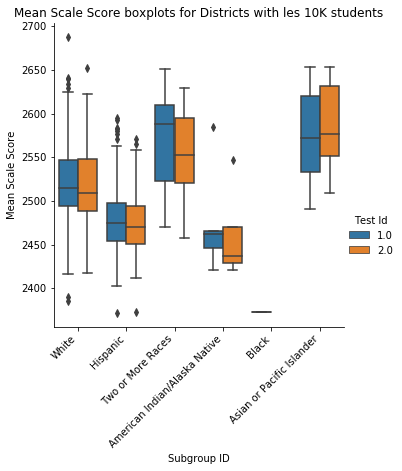

In [215]:
sns.catplot(x="Subgroup ID", y="Mean Scale Score", hue="Test Id", kind="box", data=mini_districts)
plt.xticks(rotation=45, ha='right')
_=plt.title('Mean Scale Score boxplots for Districts with les 10K students')

# When we see the distribution of revenue regardless of the size of the districts, we see a range of 4K to 14K in revenue per student.

# Will create a dataset with all districts on the lower revenue per student to see what is the size of those schools which seem to get the higher scores. See if we can find a pattern there.

In [229]:
low_revenue_df = df[df['Revenue per student'] <= 8000]
median_revenue_df=df[(df['Revenue per student'] > 8000) & (df['Revenue per student'] <= 12000)]

In [223]:
low_revenue_df['Total Enrollment'].describe()

count      1423.000000
mean       9208.479269
std       15631.776408
min         254.000000
25%        1992.000000
50%        4527.000000
75%        9911.000000
max      128040.000000
Name: Total Enrollment, dtype: float64

In [224]:
low_revenue_df['Mean Scale Score'].describe()

count    1423.000000
mean     2546.803469
std        60.665348
min      2374.200000
25%      2502.364286
50%      2547.183333
75%      2583.135714
max      2770.300000
Name: Mean Scale Score, dtype: float64

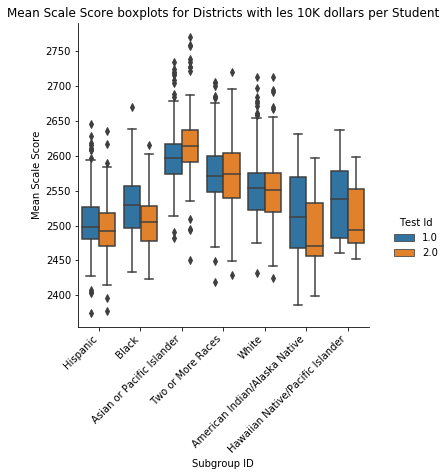

In [227]:
sns.catplot(x="Subgroup ID", y="Mean Scale Score", hue="Test Id", kind="box", data=low_revenue_df)
plt.xticks(rotation=45, ha='right')
_=plt.title('Mean Scale Score boxplots for Districts with les 8K dollars per Student')

In [230]:
#An all district groups we see the median or majority of the districts fall within this category
median_revenue_df['Total Enrollment'].describe()

count     2776.000000
mean     11832.972983
std      12909.742030
min        251.000000
25%       2801.000000
50%       8083.000000
75%      16140.000000
max      76428.000000
Name: Total Enrollment, dtype: float64

In [231]:
median_revenue_df['Revenue per student'].describe()

count     2776.000000
mean      9939.408368
std       1110.903087
min       8015.050000
25%       9024.950000
50%       9839.420000
75%      10760.360000
max      11999.510000
Name: Revenue per student, dtype: float64

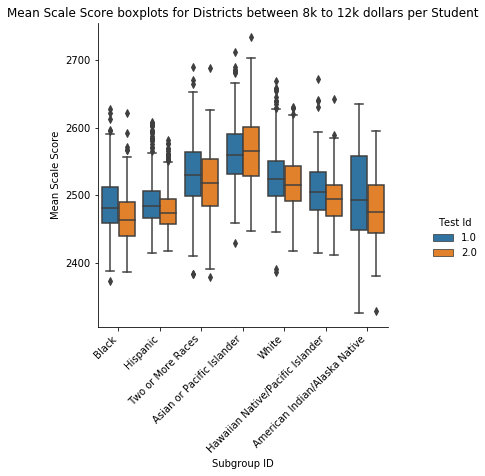

In [233]:
sns.catplot(x="Subgroup ID", y="Mean Scale Score", hue="Test Id", kind="box", data=median_revenue_df)
plt.xticks(rotation=45, ha='right')
_=plt.title('Mean Scale Score boxplots for Districts between 8k to 12k dollars per Student')

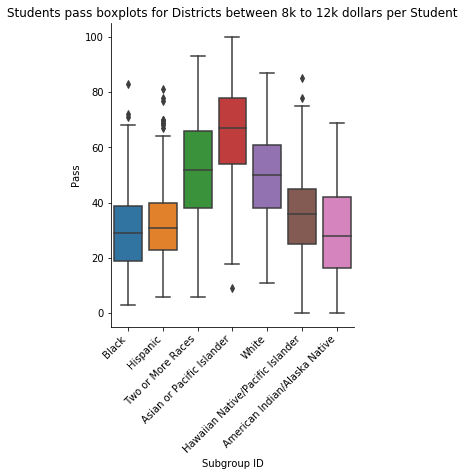

In [236]:
sns.catplot(x="Subgroup ID", y="Pass", kind="box", data=median_revenue_df)
plt.xticks(rotation=45, ha='right')
_=plt.title('Percent of Students pass boxplots for Districts between 8k to 12k dollars per Student')

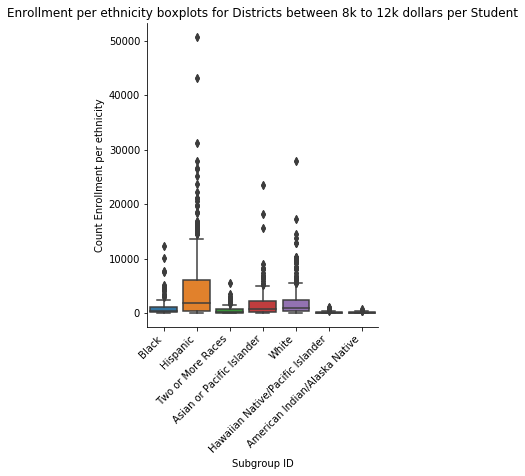

In [240]:
sns.catplot(x="Subgroup ID", y="Count Enrollment per ethnicity",kind="box", data=median_revenue_df)
plt.xticks(rotation=45, ha='right')
_=plt.title('Enrollment per ethnicity boxplots for Districts between 8k to 12k dollars per Student')

---------------

## Conclusions (as of now):
1. The correlation between revenue per student and students' outcome is a negative correlation regardless of the size in the district or the ethnic group.
2. There is also a negative correlation to District size with significative changes in the students's outcome, which show that black and hispanic students perform better on smaller Districts and have less differences with Asian and White Students.


## Observations:
1. We don't have the data overtime. It'll be hard to come to a conclusion if revenue is affecting test scores if we don't know what the test scores and revenue have been in the past.
2. Our conclusions will be based on the year we have the data for.

## NEXT STEPS:
1. How is the revenue used on schools with higher revenue? at this moment we don't have that data.
2. Where is the additional revenue coming from for the higher revenue schools.
3. Are there special programs that provide those resources? Lit2, Sports, etc. Are teachers paid more on those districts.
2. Merge poverty dataset from Census?
3. Come up with more questions to investigate?